# Building and Studying a tiny model

*Exercice 1*

Manipulate the following tiny toy example by following the indications in the python notebook file. More specifically, perform an FBA optimization, a FVA, manipulate the model,….
~~~~
R1 : 2A + B —> C
R2 : B + C —> D + 2E
R3 : 4A —> D
R4 : —> A
R5 : —> B
R6 : D —>
R7 : E —>
~~~~
Preliminary question : Try to understand how cobra allows a modelization of this model

Question 1 : Write the stoichiometric matrix

Question 2 : Write the linear system that has to be solved

Question 3 : Suppose that we observe V4 = 1 and V7 = 1 and solve the system

Question 4 : Suppose that we observe V4 = 1 and V7 = 2 and solve the system

Question 5 : All the reactions are irreversible. Plot the solution set. Suppose now that V4>1 and V7>1.

Question 6 : One has V4 < 6 and V7<4. What is the solution that maximizes V4+V7 ?

In [1]:
# Importing the cobra library
import cobra
from cobra import Model, Reaction, Metabolite

# step 1 : Constructing a metabolic model

model = Model('example_model')

# set of reactions
reactions = dict()
for i in range(1,8):
    reactions["R"+str(i)] = Reaction("R"+str(i))
    reactions["R"+str(i)].name = "R"+str(i)
    reactions["R"+str(i)].subsystem = 'Body'
    reactions["R"+str(i)].lower_bound = 0.  # This is the default
    reactions["R"+str(i)].upper_bound = 1000.  # This is the default
    #reactions["R"+str(i)].objective_coefficient = 0. # this is the default
    print ("Creating R"+str(i))
# set of metabolites
A = Metabolite('A', name='A', compartment='c')
B = Metabolite('B', name='B', compartment='c')
C = Metabolite('C', name='C', compartment='c')
D = Metabolite('D', name='D', compartment='c')
E = Metabolite('E', name='E', compartment='c')
F = Metabolite('F', name='F', compartment='c')

reactions["R1"].add_metabolites({A:-2, B:-1, C: 1})
reactions["R2"].add_metabolites({B:-1, C:-1, D: 1, E: 2})
reactions["R3"].add_metabolites({A:-4, D: 1})
reactions["R4"].add_metabolites({A:1})
reactions["R5"].add_metabolites({B:1})
reactions["R6"].add_metabolites({D: -1})
reactions["R7"].add_metabolites({E: -1})


reactions["R4"].lower_bound = 1
reactions["R4"].upper_bound = 6
reactions["R7"].lower_bound = 1
reactions["R7"].upper_bound = 4

for i in range(1,8):
    model.add_reaction(reactions["R"+str(i)])



Creating R1
Creating R2
Creating R3
Creating R4
Creating R5
Creating R6
Creating R7


A few comments on the previous cell. In order to define a model in the cobra framework, one first need to instanciate the Model class with this line

    model = Model('example_model')

We also need to define the metabolites, this is done with

    A = Metabolite('A', name='A', compartment='c'),....

Finally, we define the reactions and add then to the model...

    reactions["R1"] = Reaction("R1")
    reactions["R1"].lower_bound = 0
    reactions["R1"].upper_bound = 0
    reactions["R1"].add_metabolites({A:-2, B:-1, C: 1})
    model.add_reaction(reactions["R1"])



In [2]:
# setting the objective

model.reactions.R4.objective_coefficient=1
model.reactions.R7.objective_coefficient=1

# or alternative solution
model.objective= model.reactions.R4.flux_expression + model.reactions.R7.flux_expression

In [3]:
# Display some informations on the model (part 1)
print ("Number of metabolites = ",len(model.metabolites))
print ("Number of reactions = ",len(model.reactions))

Number of metabolites =  5
Number of reactions =  7


In [4]:
# Display some informations on the model (part 2)

print ("Reaction 2 is ", model.reactions[2].build_reaction_string(), "lb = ", model.reactions[2].lower_bound, "ub = ", model.reactions[2].upper_bound)

# Question : Write a loop in order to get all the reactions

# Notice than we can iterate on reactions (or metabolites or genes,...)

for r in model.reactions:
    print(r.name, r.build_reaction_string())




Reaction 2 is  4 A --> D lb =  0.0 ub =  1000.0
R1 2 A + B --> C
R2 B + C --> D + 2 E
R3 4 A --> D
R4  --> A
R5  --> B
R6 D --> 
R7 E --> 


# ⚠️ Important sample code

model.reactions, model.metabolites, model.genes are lists. Thus we can iterate on them....

    for r in model.reactions:
        print(r.id)
        
        
    for m in model.metabolites:
        print(m.name)

In [5]:
# Perform a FBA optimization

# performing a FBA is done by using the optimize() function that 
# construct the appropriate LP problem and call the solver.

f=model.optimize()
print ("optimal value=",f.objective_value)
print ("corresponding fluxes = ",f.fluxes)

# a nicer view with pandas library
import pandas
pandas.DataFrame.from_dict({"fluxes": f.fluxes})

optimal value= 10.0
corresponding fluxes =  R1    2.0
R2    2.0
R3    0.5
R4    6.0
R5    4.0
R6    2.5
R7    4.0
Name: fluxes, dtype: float64


,fluxes
R1,2.0
R2,2.0
R3,0.5
R4,6.0
R5,4.0
R6,2.5
R7,4.0


# ⚠️ Important sample code

For computing a FBA, we need a properly defined model with an objective function, then we use

    model.optimize()


In [6]:
# Question: Get the minimal and maximal values of all the fluxes in the solution space

# for that, we need to change the objective and perform FBAs

for r in model.reactions:
    # for the maximal value of flux v_r (r is the reaction), we set obj(v)=v_r like this
    model.objective = r.flux_expression
    # the we optimize
    vr_max = model.optimize()
    # for the minimal value of flux v_r (r is the reaction), we set obj(v)=-v_r
    # and use the fact that min(v_r) = -max(-v_r)
    model.objective = -r.flux_expression
    # the we optimize
    vr_min = model.optimize()
    print(r.id, "min : ", -vr_min.objective_value," , max : ",vr_max.objective_value)


R1 min :  0.5  , max :  2.0
R2 min :  0.5  , max :  2.0
R3 min :  -0.0  , max :  1.25
R4 min :  1.0  , max :  6.0
R5 min :  1.0  , max :  4.0
R6 min :  0.5  , max :  2.5
R7 min :  1.0  , max :  4.0


In [7]:
model.objective = model.reactions.R4.flux_expression + model.reactions.R7.flux_expression

# compare with 
import cobra
cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.9)

,minimum,maximum
R1,1.50,2.00
R2,1.50,2.00
R3,0.25,0.75
R4,5.00,6.00
R5,3.00,4.00
R6,2.25,2.50
R7,3.00,4.00


# ⚠️ Important sample code

For computing a FVA, we need a properly defined model with an objective function, then we use

    cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.9)
    
with the fraction_of_optimum parameter to set the flexibility parameter.

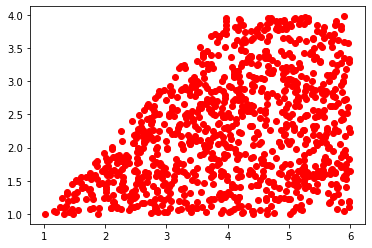

In [8]:
# Extra ! A plot of the solution space by picking randomly some fluxes 
# belonging to the solution space


nbpoints=1000
PointsR4 = list()
PointsR7 = list()
fluxes_sample = cobra.sampling.sample(model,nbpoints)

# We are only interested by V_4 and V_7
for i in range(nbpoints):
    PointsR4.append(fluxes_sample.get("R4")[i])
    PointsR7.append(fluxes_sample.get("R7")[i])


# the following plot will be an approximation of the solution space

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(PointsR4,PointsR7,"ro")
plt.show()

# Study of bigger models

*Exercise 2*

Get the ecoli_core model of Echerischia coli metabolism in the BiGG model repository here [http://bigg.ucsd.edu](http://bigg.ucsd.edu).

1. Execute a for loop on all the reactions and print their id and objective coefficient. Verify that the model possesses an objective and if not, use the model.reactions.get_by_id to set the objective coefficient of the biomass to 1.
2. Perform a FBA study. Count the number of reactions having a flux equal to zero.
3. Perform a FVA study. Report the reactions having a fixed flux. Classify the reactions into 3 classes: blocked reactions having a fixed flux equal to 0; essential reactions whose flux is either strictly positive or strictly negative; and alternative reactions whose flux can be positive or negative. 
4. Perform a FVA study at 90%. Same questions as previously.
5. Study the effect of glucose disposability (i.e., store in an array the values of the optimal biomass, obtained by a FBA study, when the lower_bound of the ‘EX_glc_D_e’ reaction range from -1000 to 0 and plot the resulting values)
6. A reaction is said to be required for biomass iff setting the reaction flux to 0 imply a decrease of the biomass growth by more than 90%. Report all the required reactions.



In [9]:
import pandas
import cobra.test

# You can use this model from the tutorial
#model = cobra.test.create_test_model("ecoli")

# or this one that must be in the home folder
model = cobra.io.read_sbml_model("e_coli_core.xml")


# ⚠️ Important sample code

Several file formats are used to store metabolic models (xml, json, mat,...). The cobra library implements several functions allowing to load a metabolic model from a file

For SBML files (requires a supplementary library and has some restrictions on the SBML version)

    model = cobra.io.read_sbml_model("filename.xml")

For JSON files

    model = cobra.io.load_json_model("filename.json")

For matlab files (mainly used for compatibility purposes with the matlab version of the cobra toolbox)

    model = cobra.io.load_matlab_model("filename.mat")
    
Notice that there also exists functions to save a cobra metabolic model into a file (cobra.io.write_sbml_model, cobra.io.save_json_model, cobra.io.save_matlab_model,...). This allows for instance to make some simple format converters.

From SBML to JSON

    model = cobra.io.read_sbml_model("filename.xml")
    cobra.io.save_json_model(model,"filename.json")
    

In [10]:
# Question: Execute a for loop on all the reactions and print their id and objective coefficient. 

for r in model.reactions:
    if not r.objective_coefficient == 0:
        print(r.id, r.objective_coefficient)

# notice that this verification is important because several models may not contains an objective function
# this test must be done before trying to compute a FBA of course

BIOMASS_Ecoli_core_w_GAM 1.0


In [11]:
# Question: how many reactions have a zero 0 for an optimal solution

# 1. perform a FBA

fba = model.optimize()

# 2. then count the number of zeros in fba.fluxes
zerofluxes = 0
for r in model.reactions:
    vr = fba.fluxes.get(r.id)
    if vr == 0:
        zerofluxes = zerofluxes + 1
print("Reaction with a null flux : ",zerofluxes)

Reaction with a null flux :  46


In [9]:
# Perform a FVA study. Classify the reactions into 3 classes.
# Blocked reactions : ----------[0]----------
# Essential reactions : ----------0--[------]-- or --[------]--0----------
# Alternative reactions : --------[--0---]-------

# 1. Computes a FVA (depending on alpha)

alpha = float(input("Enter the fraction of optimum value : "))
fva = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=alpha)

# 1. Computes the blocked and essential reactions
blocked = 0
essential = 0
for r in model.reactions:
    vr_min = fva.get("minimum").get(r.id)
    vr_max = fva.get("maximum").get(r.id)
    if (abs(vr_min)<0.00000000001 and abs(vr_max)<0.00000000001):
        blocked = blocked + 1
    if vr_min>0.00000000001 or vr_max<-0.00000000001:
        essential = essential + 1

alternative = len(model.reactions)-blocked-essential

print(blocked, "blocked reactions")
print(essential, "essential reactions")
print(alternative, "alternative reactions")



Enter the fraction of optimum value : 0.9
8 blocked reactions
31 essential reactions
56 alternative reactions


# Genetic manipulations… and metabolic engineering

*Exercise 3* 

We will now work with the ecoli test model from cobrapy that contains some genetic reaction rules. `model = cobra.test.create_test_model(‘ecoli’)`
1. Print the reaction rule of all the reactions.
2. Perform a single deletion analysis (cobra.flux_analysis.single_deletion) and report all the gene such that, when knocked out, the biomass production is less than 90% its optimal value.

*Exercise 4*

This question can be tested by using any available e. coli model…
What is the optimal O2 condition if we want to produce alcohol with e. coli ? More precisely, we want to keep e. coli alive (so biomass>90% from its optimal), optimize the ethanol production and change the O2 rate exchange to see when the ethanol production is maximal…

# Metabolism and cancer…

There exists two main models repositories containing metabolic networks relative to human health : Virtual Metabolic Human, VMH ([https://vmh.uni.lu/](https://vmh.uni.lu/)) and Human Metabolic Atlas, HMA ([http://www.metabolicatlas.org/](http://www.metabolicatlas.org/)). Take a short tour on these repositories. 

*Exercise 5*

Consider first the HMA. Take 3 models of distinct cancer and compare the models by constructing Venn diagrams comparing the common reactions, the common genes,…

Notice that you will find three models from HMA in the moodle web site formatted in JSON exchange format.
The models can be loaded in python by using the cobra.io.load_json_model function.

Venn diagrams can be displayed by using the matplotlib-venn library (see [https://pypi.org/project/matplotlib-venn/](https://pypi.org/project/matplotlib-venn/) for details).

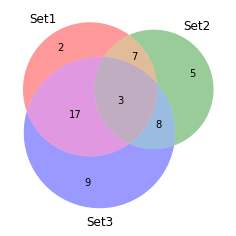

In [11]:




# An example showing how to use the matplotlib-venn library
from matplotlib_venn import venn3

only_in_1 = 2
only_in_2 = 5
only_in_3 = 9

in_1_and_2 = 7
in_1_and_3 = 17
in_2_and_3 = 8

in_1_and_2_and_3 = 3

# take care of the order
data = (only_in_1, only_in_2, in_1_and_2, only_in_3, in_1_and_3, in_2_and_3, in_1_and_2_and_3)

venn3(subsets = data, set_labels = ('Set1', 'Set2', 'Set3'))

# ✋

*Antimetabolites* are small molecules that mimics the chemical affinities of a given metabolite except, such taking its place in the chemical reactions, excepts that it blocks the functionality of the metabolite (i.e., the chemical reaction has no effects). They are commonly used as efficient cancer treatment strategies. It is thus possible, in a in silico study to block all reactions having a given metabolite as substrate and to report the metabolite having an effect on the cell growth.

*Exercise 6*

Consider the e coli model of BiGG and find antimetabolites having a putative effect. 

*Exercise 7*

The repository VMH contains the description of different diet conditions. Take some microbiote models from the download section and test the effect of different diet conditions on the biomass production and on the cholesterol export.